#### Import necessary libraries

In [1]:
import scanpy as sc
import hdf5plugin
import numpy as np
import pandas as pd
import decoupler as dc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import adata_preprocessor as ap

#### Initialize parameters

In [2]:
CLUSTER_RESOLUTION = 0.4
DATA = "CRPC"
SVD_SOLVER = "arpack"
LEIDEN_KEY = "leiden"
MIN_GENES = 1000
MAX_GENES = 10000
N_NEIGH = 10
N_PCS = 40

# Uncomment to use
# DATA = "PCa"

#### Paths for marker genes, integrated anndata object and final anndata object (cell-type annotation result)

In [3]:
MARKER_GENES = "./data/Cell_marker_Human.xlsx"

# CRPC dataset path
H5AD_PATH = "./data/GSM4089151_P1.h5ad" 

#PCa dataset path (uncomment to use)
# H5AD_PATH = "./data/GSM4773521_PCa1.h5ad" 

# Annotated dataset path
H5AD_ANNO = "./data/GSM4089151_P1_decoupleR_anno.h5ad"

# Annotated dataset path (uncomment to use)
# H5AD_ANNO = "./data/GSM4773521_PCa1_decoupleR_anno.h5ad"

#### Violin plot for leiden clusters function initialization

In [26]:
def cluster_vln_plot(melted_df):
    # Plotting
    plt.figure(figsize=(16, 6))
    ax = sns.violinplot(x='cluster', y='score', hue='cell_type', data=melted_df, 
                   inner="quartile", palette="muted", scale="count")

    # Ensuring gridlines are below plot elements
    ax.set_axisbelow(True)

    # Adding gridlines
    ax.yaxis.grid(True, color="gainsboro", linestyle="dashed")  # Horizontal gridlines

    # Compute midpoints between x-tick labels for grid placement
    xticks = ax.get_xticks()
    apoints = (xticks[:-1] + xticks[1:])
    midpoints = [i/2 for i in apoints]

    # Add vertical gridlines at midpoints
    ax.vlines(midpoints, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='lightgray', linestyles='solid', linewidth=0.5)

    # Customizing other plot elements
    # ax.set_facecolor("lightgray")
    plt.gca().set_facecolor("whitesmoke")

    plt.title(f'Violin plots of cell-type ORA scores across leiden clusters (Data: {DATA}, Leiden_res = {CLUSTER_RESOLUTION})')
    plt.ylabel('ORA score')
    plt.xlabel('Leiden cluster')

    plt.legend(title='Cell Type', bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

#### Read & preprocess dataset (cell qc & filtering)

In [5]:
adata = ap.adata_preprocessor(H5AD_PATH, n_genes_min=MIN_GENES, n_genes_max=MAX_GENES)
adata

Data shape before preprocessing: (3961, 23428)
Filtering cells with number of genes < 100: (3961, 23428)
Filtering genes expressed in < 3 cells: (3961, 20556)
Mitochondrial gene percentage calculated and annotated in the prc_mt observation
Ribosomal gene percentage calculated and annotated in the prc_rb observation
Calculate number of genes with non-zero counts
Calculate total number of counts for each cell
Filter cells with too few genes detected: (3934, 20556)
Filter cells with too many genes detected: (3934, 20556)
Filter cells with too many counts detected: (3608, 20556)
Filter cells with too many mitochondrial genes expressed: (3607, 20556)
Filter cells with too many ribosomal genes expressed: (3564, 20556)


View of AnnData object with n_obs × n_vars = 3564 × 20556
    obs: 'batch', 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts'
    var: 'n_cells'

In [6]:
# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver=SVD_SOLVER)

# # Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=N_NEIGH, n_pcs=N_PCS)

# Perform leiden clustering
sc.tl.leiden(adata, resolution = CLUSTER_RESOLUTION, key_added = LEIDEN_KEY)

# Calculate UMAP embeddings
sc.tl.umap(adata)

#### Visualize UMAP colored by leiden clusters

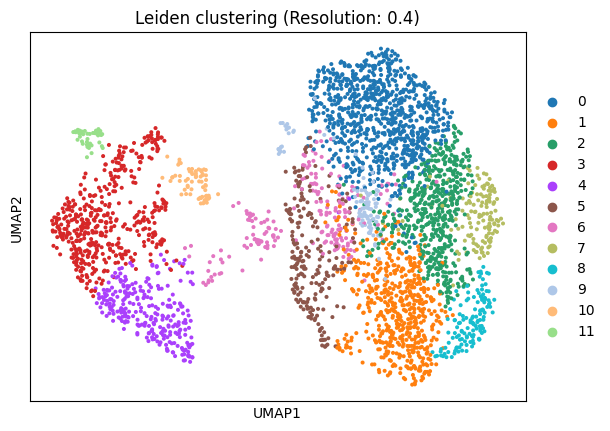

In [33]:
sc.pl.umap(
    adata, 
    color='leiden', 
    title=f'Leiden clustering (Resolution: {CLUSTER_RESOLUTION})',
    frameon=True, 
    legend_fontweight='normal', 
    legend_fontsize=10, 
)

#### Read list of markers and cell types into a pandas dataframe

In [8]:
cell_markers = pd.read_excel(MARKER_GENES)
cell_markers

,species,tissue_class,tissue_type,uberonongology_id,cancer_type,cell_type,cell_name,cellontology_id,marker,Symbol,GeneID,Genetype,Genename,UNIPROTID,technology_seq,marker_source,PMID,Title,journal,year
0,Human,Abdomen,Abdomen,UBERON_0000916,Normal,Normal cell,Macrophage,CL_0000235,MERTK,MERTK,10461.0,protein_coding,"MER proto-oncogene, tyrosine kinase",Q12866,NaN,Experiment,31982413.0,Peritoneal Level of CD206 Associates With Mort...,Gastroenterology,2020.0
1,Human,Abdomen,Abdomen,UBERON_0000916,Normal,Normal cell,Macrophage,CL_0000235,CD16,FCGR3A,2215.0,protein_coding,Fc fragment of IgG receptor IIIb,O75015,NaN,Experiment,31982413.0,Peritoneal Level of CD206 Associates With Mort...,Gastroenterology,2020.0
2,Human,Abdomen,Abdomen,UBERON_0000916,Normal,Normal cell,Macrophage,CL_0000235,CD206,MRC1,4360.0,protein_coding,mannose receptor C-type 1,P22897,NaN,Experiment,31982413.0,Peritoneal Level of CD206 Associates With Mort...,Gastroenterology,2020.0
3,Human,Abdomen,Abdomen,UBERON_0000916,Normal,Normal cell,Macrophage,CL_0000235,CRIg,VSIG4,11326.0,protein_coding,V-set and immunoglobulin domain containing 4,Q9Y279,NaN,Experiment,31982413.0,Peritoneal Level of CD206 Associates With Mort...,Gastroenterology,2020.0
4,Human,Abdomen,Abdomen,UBERON_0000916,Normal,Normal cell,Macrophage,CL_0000235,CD163,CD163,9332.0,protein_coding,CD163 molecule,Q86VB7,NaN,Experiment,31982413.0,Peritoneal Level of CD206 Associates With Mort...,Gastroenterology,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60872,Human,Vein,Vein,UBERON_0001638,Normal,Normal cell,Venous cell,NaN,LRG1,LRG1,116844.0,protein_coding,leucine rich alpha-2-glycoprotein 1,P02750,10x Chromium,Experiment,33996252.0,Single-cell transcriptomics reveals the landsc...,Molecular therapy. Nucleic acids,2021.0
60873,Human,Vein,Vein,UBERON_0001638,Normal,Normal cell,Venous cell,NaN,EMCN,EMCN,51705.0,protein_coding,endomucin,Q9ULC0,10x Chromium,Experiment,33996252.0,Single-cell transcriptomics reveals the landsc...,Molecular therapy. Nucleic acids,2021.0
60874,Human,Vein,Vein,UBERON_0001638,Normal,Normal cell,Systemic–venous endothelial cell,NaN,COL15A1,COL15A1,1306.0,protein_coding,collagen type XV alpha 1 chain,B3KTP7,10x Chromium,Experiment,34030460.0,Integrated Single-Cell Atlas of Endothelial Ce...,Circulation,2021.0
60875,Human,NaN,Intestine,UBERON_0000160,Normal,Normal cell,B cell,CL_0000236,CD19,CD19,930.0,protein_coding,CD19 molecule,P15391,10x Chromium,Experiment,34269788.0,CD16+CD163+ monocytes traffic to sites of infl...,The Journal of experimental medicine,2021.0


#### Filter cell marker dataframe to obtain markers related to Prostate

In [9]:
filtered_marker_df = ap.sanitize_cellmarker_df(cell_markers, ["tissue_class", "Prostate"], ["cell_name", "Symbol"], 1)
filtered_marker_df = filtered_marker_df[~filtered_marker_df.duplicated(['cell_name', 'Symbol'])]
filtered_marker_df

,cell_name,Symbol
51001,Early transit-amplifying prostate epithelial cell,PSCA
51002,Late transit-amplifying prostate epithelial cell,PSCA
51007,Cancer stem cell,PROM1
51009,Cancer stem cell,CD44
51021,Stem cell,PROM1
...,...,...
51274,Endothelial cell,SELE
51275,Fibroblast,FGF2
51276,T cell,CD2
51278,Endothelial cell,VWF


#### Enrichment with Over Representation Analysis (ORA)

In [10]:
dc.run_ora(
    mat=adata,
    net=filtered_marker_df,
    source='cell_name',
    target='Symbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

6 features of mat are empty, they will be removed.
Running ora on mat with 3564 samples and 20550 targets for 19 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████| 3564/3564 [00:03<00:00, 1147.30it/s]


#### The obtained scores (-log10(p-value))(ora_estimate) and p-values (ora_pvals) are stored in the .obsm key

In [11]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 3564 × 19
    obs: 'batch', 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

#### Create cell-type list and ORA-score dataframe

In [12]:
score_df = adata.obsm['ora_estimate']
ctype_lst = list(score_df.columns)
score_df["cluster"] = adata.obs["leiden"]
ctype_lst

['B cell',
 'Basal cell',
 'CD8+ T cell',
 'Cancer cell',
 'Cancer stem cell',
 'Endothelial cell',
 'Epithelial cell',
 'Fibroblast',
 'GrB+ Regulatory B cell',
 'Immune cell',
 'Luminal cell',
 'Luminal epithelial cell',
 'Macrophage',
 'Myeloid cell',
 'Natural killer cell',
 'Neuron',
 'Progenitor cell',
 'Stem cell',
 'T cell']

In [13]:
melted_df = ap.create_melted_df(score_df, ctype_lst)
melted_df

,dataset,cluster,cell_type,score
0,dataset_0,0,B cell,-0.0
1,dataset_0,0,B cell,-0.0
2,dataset_0,0,B cell,-0.0
3,dataset_0,0,B cell,-0.0
4,dataset_0,0,B cell,-0.0
...,...,...,...,...
67711,dataset_11,11,T cell,-0.0
67712,dataset_11,11,T cell,-0.0
67713,dataset_11,11,T cell,-0.0
67714,dataset_11,11,T cell,-0.0


#### Create ORA-score violin plots for all leiden clusters and cell-types

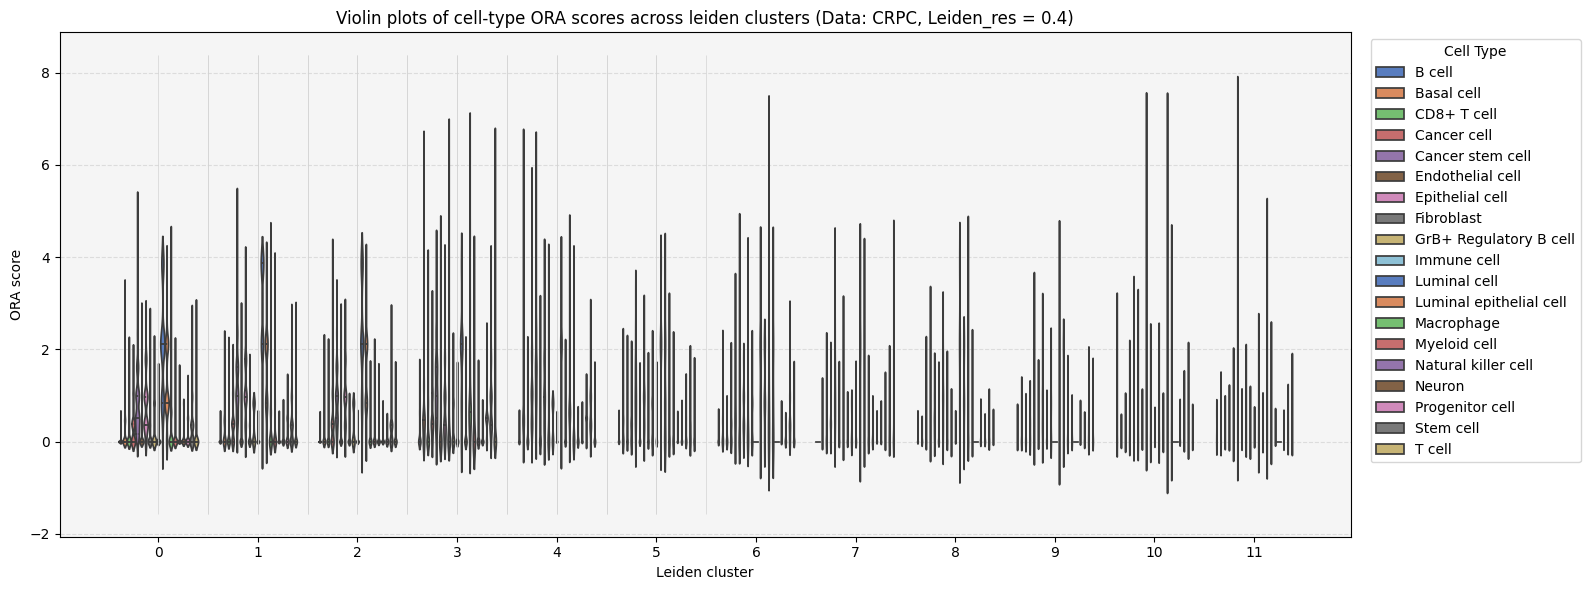

In [27]:
cluster_vln_plot(melted_df)

#### Perform statistical test to annotate cell clusters automatically

In [28]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Luminal epithelial cell,8.298120,0.326419,2.112997e-16,8.029389e-16
1,0,rest,Neuron,3.442869,0.024237,5.914646e-04,8.644483e-04
2,0,rest,Immune cell,1.504810,0.009212,1.325612e-01,1.481566e-01
3,0,rest,T cell,0.469697,0.007554,6.386296e-01,6.741090e-01
4,0,rest,CD8+ T cell,0.137781,0.002002,8.904289e-01,8.904289e-01
...,...,...,...,...,...,...,...
223,9,rest,Cancer cell,-2.165789,-0.133676,3.169146e-02,8.601968e-02
224,9,rest,Basal cell,-2.439155,-0.125361,1.593011e-02,5.044534e-02
225,9,rest,Stem cell,-2.645432,-0.154992,8.890500e-03,3.378390e-02
226,9,rest,Macrophage,-2.914973,-0.252859,4.216475e-03,2.670434e-02


In [29]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Luminal epithelial cell', 'Neuron', 'Immune cell'],
 '1': ['Luminal cell', 'Luminal epithelial cell', 'Epithelial cell'],
 '10': ['Fibroblast', 'Macrophage', 'Myeloid cell'],
 '11': ['Endothelial cell', 'B cell', 'Macrophage'],
 '2': ['Luminal epithelial cell', 'Epithelial cell', 'Luminal cell'],
 '3': ['Progenitor cell', 'Stem cell', 'Macrophage'],
 '4': ['Progenitor cell', 'Cancer cell', 'Basal cell'],
 '5': ['GrB+ Regulatory B cell', 'Cancer stem cell', 'Luminal cell'],
 '6': ['Myeloid cell', 'Macrophage', 'Fibroblast'],
 '7': ['Epithelial cell', 'Cancer stem cell', 'Luminal cell'],
 '8': ['Cancer cell', 'Luminal epithelial cell', 'GrB+ Regulatory B cell'],
 '9': ['Luminal epithelial cell', 'B cell', 'CD8+ T cell']}

In [30]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Luminal epithelial cell',
 '1': 'Luminal cell',
 '10': 'Fibroblast',
 '11': 'Endothelial cell',
 '2': 'Luminal epithelial cell',
 '3': 'Progenitor cell',
 '4': 'Progenitor cell',
 '5': 'GrB+ Regulatory B cell',
 '6': 'Myeloid cell',
 '7': 'Epithelial cell',
 '8': 'Cancer cell',
 '9': 'Luminal epithelial cell'}

In [31]:
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

#### Visualize final cell-type annotation result

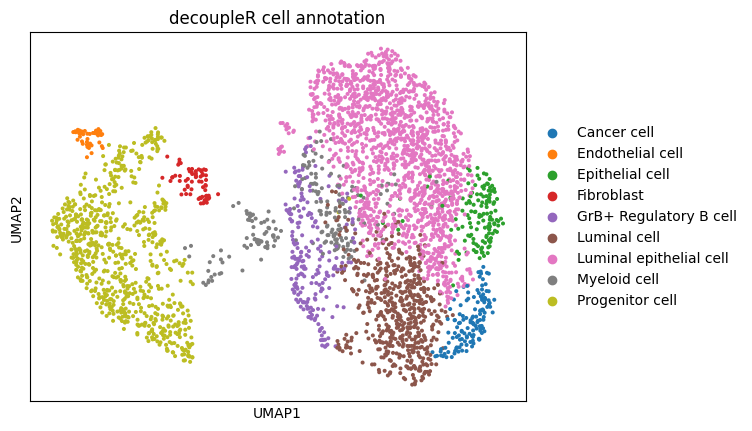

In [34]:
sc.pl.umap(
    adata, 
    color='cell_type', 
    title='decoupleR cell annotation',
    frameon=True, 
    legend_fontweight='normal', 
    legend_fontsize=10, 
)

#### Save annotated dataset to disk

In [ ]:
adata.write_h5ad(
    H5AD_ANNO,
    compression=hdf5plugin.FILTERS["zstd"]
)